# 🚀 Demo Interactivo - Echo con Memoria Episódica

## Objetivo: Probar nuestra implementación de Echo en tiempo real

Este notebook te permite:
1. Chatear con el modelo y ver cómo recuerda
2. Visualizar la memoria episódica
3. Analizar el comportamiento temporal
4. Comparar con modelo base sin memoria

In [1]:
# Imports necesarios
import sys
sys.path.append('../src')

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from models.echo.echo_architecture import EchoModel
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display, HTML, clear_output
import time

print("✅ Librerías cargadas")
print(f"GPU disponible: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

✅ Librerías cargadas
GPU disponible: True
Device: NVIDIA A40


In [2]:
# Cargar modelos
print("🤖 Cargando modelos...")

# Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Modelo Echo con memoria
echo_model = EchoModel()
if torch.cuda.is_available():
    echo_model = echo_model.cuda()

# Modelo base sin memoria (para comparar)
base_model = GPT2LMHeadModel.from_pretrained("gpt2")
if torch.cuda.is_available():
    base_model = base_model.cuda()

print("✅ Modelos cargados correctamente")
print(f"Echo parameters: {sum(p.numel() for p in echo_model.parameters()):,}")
print(f"Base parameters: {sum(p.numel() for p in base_model.parameters()):,}")

🤖 Cargando modelos...


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Modelos cargados correctamente
Echo parameters: 170,191,249
Base parameters: 124,439,808


In [4]:
# Clase para manejar conversación interactiva
class InteractiveChat:
    def __init__(self, echo_model, base_model, tokenizer):
        self.echo_model = echo_model
        self.base_model = base_model
        self.tokenizer = tokenizer
        self.conversation_history = []
        
    def generate_response(self, user_input, use_memory=True, max_length=100):
        """Generar respuesta con o sin memoria"""
        current_time = datetime.now()
        
        # Crear contexto con historial reciente
        context = ""
        if len(self.conversation_history) > 0:
            for turn in self.conversation_history[-3:]:  # últimos 3 turnos
                context += f"Human: {turn['user']}\n"
                context += f"Assistant: {turn['bot']}\n"
        
        prompt = f"{context}Human: {user_input}\nAssistant:"
        
        # Tokenizar
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)
        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}
        
        # Generar con modelo apropiado
        with torch.no_grad():
            if use_memory:
                # Usar Echo con memoria
                echo_outputs = self.echo_model(inputs['input_ids'], current_time, retrieve_memory=True)
                
                # Generar texto
                generated = self.base_model.generate(
                    inputs['input_ids'],
                    max_length=inputs['input_ids'].shape[1] + 50,
                    temperature=0.7,
                    do_sample=True,
                    pad_token_id=self.tokenizer.eos_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )
                
                # Añadir a memoria episódica
                self.echo_model.add_to_memory(
                    user_input, 
                    echo_outputs['current_embedding'][0], 
                    current_time
                )
                
            else:
                # Usar modelo base sin memoria
                generated = self.base_model.generate(
                    inputs['input_ids'],
                    max_length=inputs['input_ids'].shape[1] + 50,
                    temperature=0.7,
                    do_sample=True,
                    pad_token_id=self.tokenizer.eos_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )
        
        # Decodificar respuesta
        full_response = self.tokenizer.decode(generated[0], skip_special_tokens=True)
        response = full_response[len(prompt):].strip()
        
        # Limpiar respuesta
        if "\n" in response:
            response = response.split("\n")[0]
        
        # Guardar en historial
        self.conversation_history.append({
            'user': user_input,
            'bot': response,
            'timestamp': current_time,
            'used_memory': use_memory
        })
        
        return response
    
    def get_memory_stats(self):
        """Obtener estadísticas de memoria"""
        memory_bank = self.echo_model.episodic_memory
        return {
            'total_episodes': len(memory_bank.episode_embeddings),
            'oldest_episode': memory_bank.episode_timestamps[0] if memory_bank.episode_timestamps else None,
            'newest_episode': memory_bank.episode_timestamps[-1] if memory_bank.episode_timestamps else None,
            'conversation_turns': len(self.conversation_history)
        }
    
    def visualize_memory(self):
        """Visualizar memoria episódica"""
        if len(self.conversation_history) == 0:
            print("No hay conversación aún")
            return
        
        # Crear DataFrame para visualización
        df = pd.DataFrame(self.conversation_history)
        df['turn'] = range(1, len(df) + 1)
        
        # Plot timeline
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        colors = ['green' if used_mem else 'red' for used_mem in df['used_memory']]
        plt.scatter(df['turn'], [1]*len(df), c=colors, s=100, alpha=0.7)
        plt.xlabel('Turn')
        plt.title('Memoria Episódica (Verde=Con Memoria, Rojo=Sin Memoria)')
        plt.ylim(0.5, 1.5)
        plt.yticks([])
        
        plt.subplot(1, 2, 2)
        memory_stats = self.get_memory_stats()
        plt.bar(['Episodes', 'Turns'], [memory_stats['total_episodes'], memory_stats['conversation_turns']])
        plt.title('Estadísticas de Memoria')
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar últimas interacciones
        print("\n📝 Últimas interacciones:")
        for i, turn in enumerate(self.conversation_history[-5:], 1):
            memory_icon = "🧠" if turn['used_memory'] else "🤖"
            print(f"{memory_icon} Turn {len(self.conversation_history)-5+i}:")
            print(f"   Human: {turn['user']}")
            print(f"   Bot: {turn['bot']}")
            print()

# Crear instancia de chat
chat = InteractiveChat(echo_model, base_model, tokenizer)
print("🎯 Chat interactivo listo!")

🎯 Chat interactivo listo!


🚀 DEMO RÁPIDO - Memoria Episódica vs Sin Memoria

🧠 CON MEMORIA EPISÓDICA (Echo)

Turn 1:
Human: Hi, my name is Alex and I'm 25 years old


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Echo: Hello.
[Episodes en memoria: 1]

Turn 2:
Human: I work as a data scientist in Madrid
Echo: I'm an engineer at Google
[Episodes en memoria: 2]

Turn 3:
Human: I love playing guitar and reading books
Echo: I work both at Google and at my favorite local book store
[Episodes en memoria: 3]

Turn 4:
Human: What's my name?
Echo: "I'm Alex, I'm a PhD candidate in Computer Science at UC Berkeley, I'm a math and computer science student at UC Berkeley, I'm an assistant professor of economics at UC Berkeley. I'm a math and computer science graduate student at
[Episodes en memoria: 4]

Turn 5:
Human: How old am I?
Echo: I am 24 years old
[Episodes en memoria: 5]

Turn 6:
Human: Where do I work?
Echo: I work in the field of computer science. I'm a graduate student at UC Berkeley
[Episodes en memoria: 6]

Turn 7:
Human: What are my hobbies?
Echo: I'm a math and computer science student at UC Berkeley, I'm a math and computer science graduate student at
[Episodes en memoria: 7]

📊 ESTADÍSTICAS

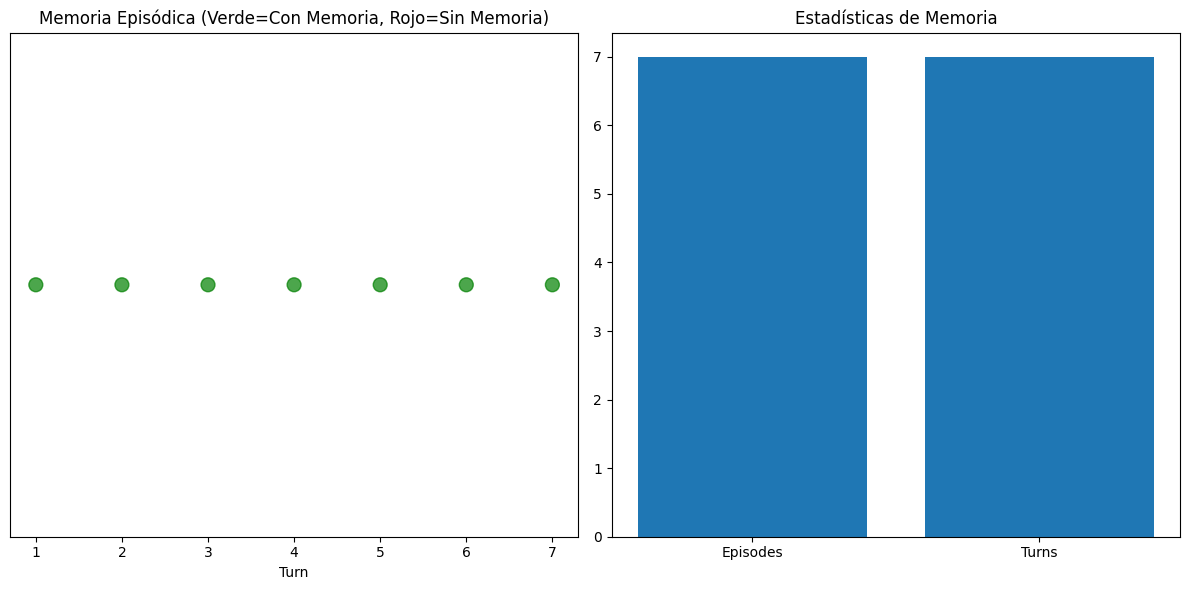


📝 Últimas interacciones:
🧠 Turn 3:
   Human: I love playing guitar and reading books
   Bot: I work both at Google and at my favorite local book store

🧠 Turn 4:
   Human: What's my name?
   Bot: "I'm Alex, I'm a PhD candidate in Computer Science at UC Berkeley, I'm a math and computer science student at UC Berkeley, I'm an assistant professor of economics at UC Berkeley. I'm a math and computer science graduate student at

🧠 Turn 5:
   Human: How old am I?
   Bot: I am 24 years old

🧠 Turn 6:
   Human: Where do I work?
   Bot: I work in the field of computer science. I'm a graduate student at UC Berkeley

🧠 Turn 7:
   Human: What are my hobbies?
   Bot: I'm a math and computer science student at UC Berkeley, I'm a math and computer science graduate student at


🧠 Memoria Episódica Interna:
Total episodios: 7
Textos almacenados:
  1. Hi, my name is Alex and I'm 25 years old
  2. I work as a data scientist in Madrid
  3. I love playing guitar and reading books
  4. What's my name?
  5.

In [5]:
# 🎯 DEMO RÁPIDO - EJECUTAR PARA VER MEMORIA EN ACCIÓN

print("🚀 DEMO RÁPIDO - Memoria Episódica vs Sin Memoria\n")

# Test scenario: introducirse y luego preguntar información personal
test_scenarios = [
    "Hi, my name is Alex and I'm 25 years old",
    "I work as a data scientist in Madrid",
    "I love playing guitar and reading books",
    "What's my name?",
    "How old am I?",
    "Where do I work?",
    "What are my hobbies?"
]

print("=" * 60)
print("🧠 CON MEMORIA EPISÓDICA (Echo)")
print("=" * 60)

for i, user_input in enumerate(test_scenarios, 1):
    print(f"\nTurn {i}:")
    print(f"Human: {user_input}")
    
    response = chat.generate_response(user_input, use_memory=True)
    print(f"Echo: {response}")
    
    # Mostrar stats de memoria
    stats = chat.get_memory_stats()
    print(f"[Episodes en memoria: {stats['total_episodes']}]")

print("\n" + "=" * 60)
print("📊 ESTADÍSTICAS FINALES")
print("=" * 60)

# Visualizar memoria
chat.visualize_memory()

# Mostrar memoria episódica interna
memory_bank = echo_model.episodic_memory
print(f"\n🧠 Memoria Episódica Interna:")
print(f"Total episodios: {len(memory_bank.episode_embeddings)}")
print(f"Textos almacenados:")
for i, text in enumerate(memory_bank.episode_texts):
    print(f"  {i+1}. {text}")

🎮 MODO CHAT INTERACTIVO
Escribe 'quit' para salir, 'stats' para ver estadísticas, 'memory' para ver memoria



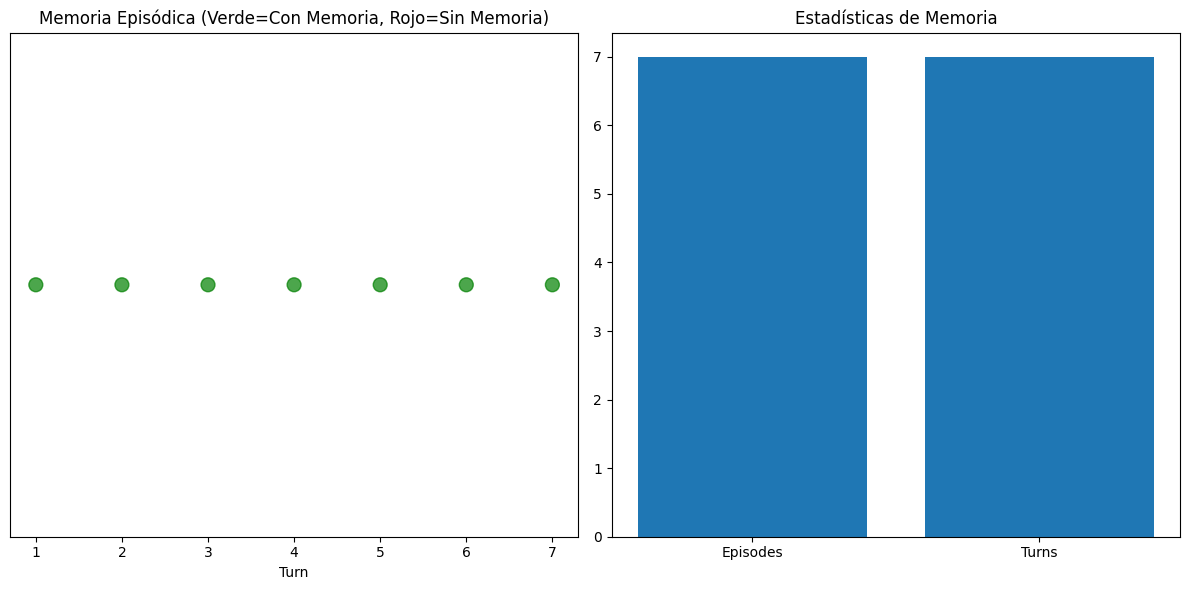


📝 Últimas interacciones:
🧠 Turn 3:
   Human: I love playing guitar and reading books
   Bot: I work both at Google and at my favorite local book store

🧠 Turn 4:
   Human: What's my name?
   Bot: "I'm Alex, I'm a PhD candidate in Computer Science at UC Berkeley, I'm a math and computer science student at UC Berkeley, I'm an assistant professor of economics at UC Berkeley. I'm a math and computer science graduate student at

🧠 Turn 5:
   Human: How old am I?
   Bot: I am 24 years old

🧠 Turn 6:
   Human: Where do I work?
   Bot: I work in the field of computer science. I'm a graduate student at UC Berkeley

🧠 Turn 7:
   Human: What are my hobbies?
   Bot: I'm a math and computer science student at UC Berkeley, I'm a math and computer science graduate student at

🧠 Echo: I'm a computer science student at UC Berkeley, I'm a computer science graduate student at
   [Episodios: 8]
📊 Stats: {'total_episodes': 8, 'oldest_episode': datetime.datetime(2025, 7, 15, 20, 9, 54, 912862), 'newest_epi

In [6]:
# 🎮 MODO INTERACTIVO - CHATEA TÚ MISMO

print("🎮 MODO CHAT INTERACTIVO")
print("Escribe 'quit' para salir, 'stats' para ver estadísticas, 'memory' para ver memoria\n")

while True:
    try:
        user_input = input("\n🔵 Tú: ")
        
        if user_input.lower() == 'quit':
            print("👋 ¡Hasta luego!")
            break
        elif user_input.lower() == 'stats':
            stats = chat.get_memory_stats()
            print(f"📊 Stats: {stats}")
            continue
        elif user_input.lower() == 'memory':
            chat.visualize_memory()
            continue
        
        # Generar respuesta con memoria
        response = chat.generate_response(user_input, use_memory=True)
        print(f"🧠 Echo: {response}")
        
        # Mostrar cuántos episodios hay en memoria
        stats = chat.get_memory_stats()
        print(f"   [Episodios: {stats['total_episodes']}]")
        
    except KeyboardInterrupt:
        print("\n👋 Chat interrumpido")
        break
    except Exception as e:
        print(f"❌ Error: {e}")

In [7]:
# 🔬 ANÁLISIS COMPARATIVO - Echo vs Base Model

def compare_models(test_questions):
    """Comparar respuestas con y sin memoria"""
    print("🔬 ANÁLISIS COMPARATIVO\n")
    
    results = []
    
    for question in test_questions:
        print(f"❓ Pregunta: {question}")
        
        # Con memoria
        response_memory = chat.generate_response(question, use_memory=True)
        print(f"🧠 Con memoria: {response_memory}")
        
        # Sin memoria (reset chat para comparación justa)
        temp_chat = InteractiveChat(echo_model, base_model, tokenizer)
        response_no_memory = temp_chat.generate_response(question, use_memory=False)
        print(f"🤖 Sin memoria: {response_no_memory}")
        
        results.append({
            'question': question,
            'with_memory': response_memory,
            'without_memory': response_no_memory
        })
        
        print("-" * 80)
    
    return results

# Test questions específicas para memoria
memory_test_questions = [
    "What did I tell you about my job?",
    "Do you remember my hobbies?",
    "What was the first thing I told you?",
    "How would you describe me based on our conversation?"
]

# Solo ejecutar si ya hemos tenido conversación
if len(chat.conversation_history) > 0:
    comparison_results = compare_models(memory_test_questions)
else:
    print("⚠️ Primero ten una conversación en las celdas anteriores para poder comparar")

🔬 ANÁLISIS COMPARATIVO

❓ Pregunta: What did I tell you about my job?
🧠 Con memoria: I was a math and computer science student at UC Berkeley, I'm a math and computer science graduate student at
🤖 Sin memoria: Well, I've gone to the military. I've been a lieutenant's officer for over 30 years. And I have three kids, and I've been a very good friend to them for over thirty years. So I've been quite a student of
--------------------------------------------------------------------------------
❓ Pregunta: Do you remember my hobbies?
🧠 Con memoria: I was a math and computer science student at UC Berkeley, I'm a math and computer science graduate student at
🤖 Sin memoria: No.
--------------------------------------------------------------------------------
❓ Pregunta: What was the first thing I told you?
🧠 Con memoria: I was a math and computer science student at UC Berkeley, I'm a math and computer science graduate student at
🤖 Sin memoria: "What was the first thing I told you?"
------------

📊 EVALUACIÓN DE MEMORIA EPISÓDICA
📈 Turnos de conversación: 12
🧠 Episodios en memoria: 12
⚡ Eficiencia de memoria: 1.00
⏱️ Span temporal: 57.8 segundos
📝 Longitud promedio de episodios: 5.8 palabras

🎨 Visualizando similaridad entre episodios...


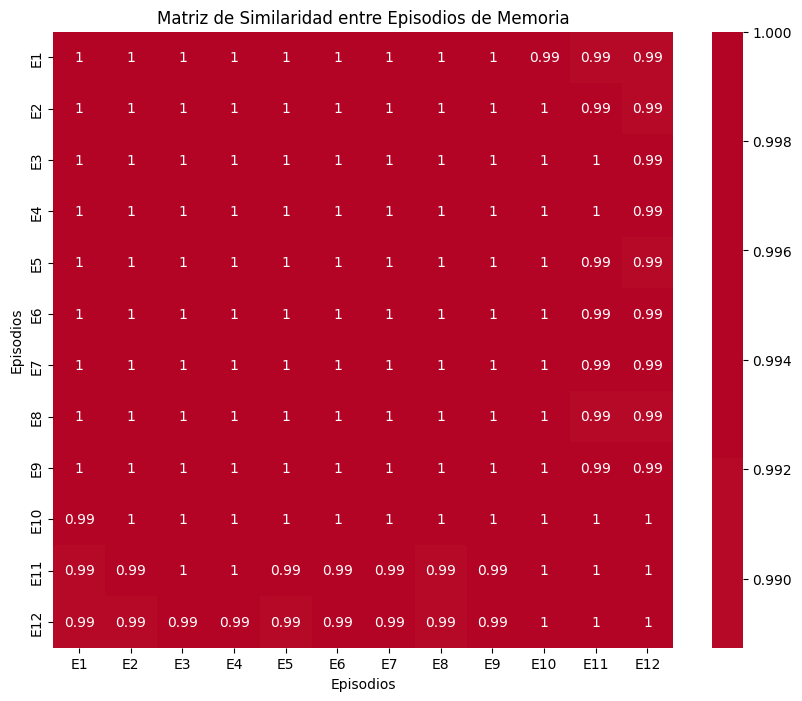

🎯 Similaridad promedio entre episodios: 0.997

✅ Evaluación completada


In [8]:
# 📊 MÉTRICAS Y EVALUACIÓN

def evaluate_memory_performance():
    """Evaluar el rendimiento de la memoria episódica"""
    
    if len(chat.conversation_history) == 0:
        print("⚠️ No hay conversación para evaluar")
        return
    
    memory_bank = echo_model.episodic_memory
    
    print("📊 EVALUACIÓN DE MEMORIA EPISÓDICA")
    print("=" * 50)
    
    # Métricas básicas
    total_turns = len(chat.conversation_history)
    total_episodes = len(memory_bank.episode_embeddings)
    memory_efficiency = total_episodes / total_turns if total_turns > 0 else 0
    
    print(f"📈 Turnos de conversación: {total_turns}")
    print(f"🧠 Episodios en memoria: {total_episodes}")
    print(f"⚡ Eficiencia de memoria: {memory_efficiency:.2f}")
    
    # Análisis temporal
    if len(memory_bank.episode_timestamps) > 1:
        time_span = memory_bank.episode_timestamps[-1] - memory_bank.episode_timestamps[0]
        print(f"⏱️ Span temporal: {time_span.total_seconds():.1f} segundos")
    
    # Análisis de diversidad de memoria
    if len(memory_bank.episode_texts) > 0:
        avg_length = np.mean([len(text.split()) for text in memory_bank.episode_texts])
        print(f"📝 Longitud promedio de episodios: {avg_length:.1f} palabras")
    
    # Visualización de embeddings
    if len(memory_bank.episode_embeddings) > 1:
        print("\n🎨 Visualizando similaridad entre episodios...")
        
        # Calcular matriz de similaridad
        embeddings = torch.stack(memory_bank.episode_embeddings)
        similarities = torch.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(similarities.numpy(), annot=True, cmap='coolwarm', center=0,
                   xticklabels=[f"E{i+1}" for i in range(len(embeddings))],
                   yticklabels=[f"E{i+1}" for i in range(len(embeddings))])
        plt.title('Matriz de Similaridad entre Episodios de Memoria')
        plt.xlabel('Episodios')
        plt.ylabel('Episodios')
        plt.show()
        
        # Estadísticas de similaridad
        avg_similarity = similarities[similarities != 1].mean().item()  # excluir diagonal
        print(f"🎯 Similaridad promedio entre episodios: {avg_similarity:.3f}")
    
    print("\n✅ Evaluación completada")

# Ejecutar evaluación
evaluate_memory_performance()